# Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)

1. Load patient data and sample data. Join the two tables and remove the obvious useless columns from the two tables.
1. Perform a detailed analysis of the columns left in the dataset to decide which ones to keep. After this, all columns of X are ready for model development.
1. Prepare the target column y.
1. Since X and y are ready, pass X,y through popular ML models and assess performance.

Note: This notebook was used just to create the pipeline. The pipeline will be reused but the prediction task itself is naive.

In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from helpers import load_config, plot_predicted_vs_actual
from colorectal_adenocarcinoma.data_preprocessor import preprocess_data
import sys
import os
import warnings
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from  colorectal_adenocarcinoma.model_evaluators import multiclass_classification, plot_feature_importance_plot_using_rf
import seaborn as sns

warnings.filterwarnings("ignore")


In [3]:
configs = load_config(os.path.join("configs", "configs.yaml"))

## 1. Load patient and sample data and remove obvious useless columns

#### 1.1 Reading and exploring data clinical patient file

In [4]:
study_path = configs["STORAGE_DIR_STUDY2"]

In [5]:
patientdf = pd.read_csv(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "data_clinical_patient.txt"),
    sep="\t",
    header=4
)
patientdf.head()

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
0,TCGA-3L-AA1B,COAD_CIN,COAD,A94E1279-A975-480A-93E9-7B1FF05CBCBF,61.0,Female,STAGE I,7TH,475.0,-22379.0,...,Yes,0:LIVING,15.616267,0:ALIVE OR DEAD TUMOR FREE,15.616267,0:DiseaseFree,15.616267,0:CENSORED,15.616267,AFR_ADMIX
1,TCGA-4N-A93T,COAD_CIN,COAD,92554413-9EBC-4354-8E1B-9682F3A031D9,67.0,Male,STAGE IIIB,7TH,146.0,-24523.0,...,Yes,0:LIVING,4.799947,0:ALIVE OR DEAD TUMOR FREE,4.799947,NaN,NaN,0:CENSORED,4.799947,AFR
2,TCGA-4T-AA8H,COAD_CIN,COAD,A5E14ADD-1552-4606-9FFE-3A03BCF76640,42.0,Female,STAGE IIA,7TH,385.0,-15494.0,...,Yes,0:LIVING,12.657396,0:ALIVE OR DEAD TUMOR FREE,12.657396,0:DiseaseFree,12.657396,0:CENSORED,12.657396,AFR_ADMIX
3,TCGA-5M-AAT4,COAD_CIN,COAD,1136DD50-242A-4659-AAD4-C53F9E759BB3,74.0,Male,STAGE IV,6TH,NaN,-27095.0,...,Yes,1:DECEASED,1.610941,1:DEAD WITH TUMOR,1.610941,NaN,NaN,1:PROGRESSION,1.610941,AFR
4,TCGA-5M-AAT6,COAD_MSI,COAD,CE00896A-F7D2-4123-BB95-24CB6E53FC32,40.0,Female,STAGE IV,6TH,NaN,-14852.0,...,Yes,1:DECEASED,9.534142,1:DEAD WITH TUMOR,9.534142,NaN,NaN,1:PROGRESSION,7.199921,AFR


In [6]:
columns_being_discarded =  [
    # 'SUBTYPE', # consider for later analysis
    'CANCER_TYPE_ACRONYM', # same value for all records
    'OTHER_PATIENT_ID', # id column not related to any data of our interest
    'AJCC_STAGING_EDITION', # version of handbook used for classification
    'DAYS_LAST_FOLLOWUP', # similar but more relevant information captured in OS_Months
    'DAYS_TO_BIRTH', # age captures similar information 
    'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', # similar but more relevant information captured in OS_Months 
    'ETHNICITY', # race column has more rich data
    'FORM_COMPLETION_DATE', # irrelevant to analysis
    'HISTORY_NEOADJUVANT_TRTYN', # highly skewed, 590 No, 2 Yes, 2 Null
    'ICD_O_3_HISTOLOGY' , # which edition of certain code used for tabulating data
    'ICD_O_3_SITE', # which edition of certain code used for tabulating data
    'INFORMED_CONSENT_VERIFIED', # irrelevant to analysis
    'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', # highly skewed 557 Yes, 19 No, 18 Null
    'IN_PANCANPATHWAYS_FREEZE', # if patient is part of a certain analysis, irrelevant
    ]

In [7]:
patientdf_1 = patientdf.drop(columns=columns_being_discarded)
patientdf_1.shape

(594, 24)

#### 1.2 Reading and exploring data clinical sample 

In [8]:
sampledf = pd.read_csv(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "data_clinical_sample.txt"),
    sep="\t",
    header=4
)
sampledf.head()

,PATIENT_ID,SAMPLE_ID,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,TISSUE_PROSPECTIVE_COLLECTION_INDICATOR,TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR,TISSUE_SOURCE_SITE_CODE,TUMOR_TISSUE_SITE,ANEUPLOIDY_SCORE,SAMPLE_TYPE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,SOMATIC_STATUS,TMB_NONSYNONYMOUS,TISSUE_SOURCE_SITE
0,TCGA-AF-2687,TCGA-AF-2687-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,24.0,Primary,0.3529,0.08,Matched,3.266667,Albert Einstein Medical Center
1,TCGA-AF-2689,TCGA-AF-2689-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,18.0,Primary,0.3486,1.28,Matched,1.733333,Mary Bird Perkins Cancer Center - Our Lady of ...
2,TCGA-AF-2690,TCGA-AF-2690-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,25.0,Primary,0.3412,0.03,Matched,2.366667,Duke University
3,TCGA-AF-2691,TCGA-AF-2691-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,11.0,Primary,0.3267,1.16,Matched,2.233333,University of Sao Paulo
4,TCGA-AF-2692,TCGA-AF-2692-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectum Adenocarcinoma,NaN,Yes,No,AF,NaN,16.0,Primary,0.3259,1.32,Matched,0.733333,University of Sao Paulo


In [9]:
sampledf.shape

(594, 18)

In [10]:
subset_sample = sampledf.head().T

In [11]:
columns_being_discarded_sampledf = [
    'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR', # when sample was collected, before or after
    'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', # when sample was collected, before or after
    'TISSUE_SOURCE_SITE_CODE', # which hospital was the sample collected at
    'TUMOR_TISSUE_SITE', # part of body where sample was collected
    'SAMPLE_TYPE', # has only one value "Primary"
    'TISSUE_SOURCE_SITE' # which hospital was the sample collected at
]

In [12]:
sampledf_1 = sampledf.drop(columns=columns_being_discarded_sampledf)
sampledf_1.shape, patientdf_1.shape

((594, 12), (594, 24))

In [13]:
sampledf_1.shape, patientdf_1.shape

((594, 12), (594, 24))

#### 1.3 Joining patient and sample data 

In [14]:
df = pd.merge(patientdf_1, sampledf_1, on='PATIENT_ID', how='inner')
df.head()

,PATIENT_ID,SUBTYPE,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,ICD_10,NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,...,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,SOMATIC_STATUS,TMB_NONSYNONYMOUS
0,TCGA-3L-AA1B,COAD_CIN,61.0,Female,STAGE I,C18.0,No,M0,N0,T2,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,19.0,0.3057,0.05,Matched,4.033333
1,TCGA-4N-A93T,COAD_CIN,67.0,Male,STAGE IIIB,C18.2,No,M0,N1B,T4A,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,13.0,0.3317,0.69,Matched,2.900000
2,TCGA-4T-AA8H,COAD_CIN,42.0,Female,STAGE IIA,C18.6,No,MX,N0,T3,...,MACR,Colorectal Cancer,Mucinous Adenocarcinoma of the Colon and Rectum,"Colon Adenocarcinoma, Mucinous Type",NaN,18.0,0.3144,0.17,Matched,4.000000
3,TCGA-5M-AAT4,COAD_CIN,74.0,Male,STAGE IV,C18.2,No,M1B,N0,T3,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,18.0,0.3232,0.55,Matched,5.833333
4,TCGA-5M-AAT6,COAD_MSI,40.0,Female,STAGE IV,C18.2,Yes,M1A,N2B,T4A,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,3.0,0.6600,20.58,Matched,62.166667


In [15]:
df.to_excel(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "user_friendly_formats", "raw_patient_sample_merge.xlsx")
)

## 2. Detailed Analysis of Columns left to construct X

#### 2.1 Apply data transformations

##### Data Specifications for the pipeline:
1. GENETIC_ANCESTRY_LABEL: 
    - has values like [' ', 'AFR', 'AFR_ADMIX', 'EAS', 'EUR', 'EUR_ADMIX']
    - highly skewed toward EUR. 
    - output 1 for EUR(white), 0 for non-EUR(non-white).
    - potentially modify later to include other races if good number of records are available.

1. PRIOR_DX
    - starts with either Yes or No. 

1. PATH_M_STAGE
    - contains values out of [M0, M1, M1A, M1B, MX]

1. PATH_T_STAGE
    - contains values out of ['T1', 'T2', 'T3', 'T4', 'T4A', 'T4B', 'TIS']

1. PATH_N_STAGE
    - contains values out of ['N0', 'N1', 'N1A', 'N1B', 'N1C', 'N2', 'N2A', 'N2B'] 

1. All other columns are either object type or int64 type.




In [16]:
columns_to_drop = [
    'GRADE',
    'DFS_MONTHS', 'DFS_STATUS',
    'SUBTYPE', 'ICD_10',
    'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT',
    'DSS_STATUS', 'DSS_MONTHS',
    'AJCC_PATHOLOGIC_TUMOR_STAGE',
    'SOMATIC_STATUS',
    'TUMOR_TYPE',
    'CANCER_TYPE',
    'RACE',
    'CANCER_TYPE_DETAILED', 
    "OS_STATUS", "OS_MONTHS"
]

df = df.drop(columns=columns_to_drop)

In [18]:
df.to_csv(
    os.path.join(study_path, "all_patient_sample_merge_relevant_columns.csv"),
    index=False
)

In [17]:
df1 = df.dropna()
df.shape, df1.shape

((594, 19), (243, 19))

In [18]:
df1 = df1[df1["PFS_STATUS"] == "1:PROGRESSION"]
df1.drop(["PFS_STATUS"], axis=1, inplace=True)
df1.shape

(63, 18)

In [19]:
# save cleaned data for use later
df1.to_csv(
    os.path.join(
        study_path, "pathological_df.csv"
    ), 
    index=False
)

In [20]:
df2 = df1.drop(["PATIENT_ID", "SAMPLE_ID"], axis=1)
X = df2.drop(["PFS_MONTHS"], axis=1)
y = df2.PFS_MONTHS

In [21]:
X = preprocess_data(X)
X.head()

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


,AGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,WEIGHT,GENETIC_ANCESTRY_LABEL,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,SEX_Male,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,PRIOR_DX_Y,RADIATION_THERAPY_Yes,ONCOTREE_CODE_MACR,ONCOTREE_CODE_READ
4,40.0,1.0,2.5,4.0,99.1,0,3.0,0.6600,20.58,62.166667,0,1,0,0,0,0
5,76.0,0.0,0.0,3.0,75.4,0,20.0,0.3252,0.47,3.800000,1,1,0,0,0,0
6,85.0,1.0,2.0,3.0,67.2,1,25.0,0.3500,0.37,4.066667,1,1,0,0,0,0
8,71.0,1.0,2.0,3.0,85.6,1,24.0,0.4577,0.02,7.666667,1,0,0,0,1,0
15,73.0,0.0,0.0,3.0,79.6,1,13.0,0.3456,0.13,8.666667,0,0,1,0,0,0


## 3. Preparing X and y for multiclass classification 

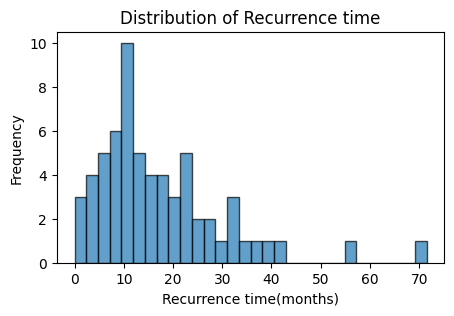

In [22]:
# Plot the distribution
plt.figure(figsize=(5, 3))
plt.hist(df1['PFS_MONTHS'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Recurrence time')
plt.xlabel('Recurrence time(months)')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [23]:
def create_bins(df2:pd.DataFrame, binning_col='PFS_MONTHS', num_of_bins = 5):
    """
    Function takes dataframe and number of bins as input and slots the data into equal sized bins. 
    Returns the dataframe with new column named {binning_col}_BINNED and bin ranges for each label.
    """
    df = df2.copy()
    df[f'{binning_col}_BINNED'] = pd.qcut(df[binning_col], q=num_of_bins, labels=False)
    bin_ranges = df.groupby(f'{binning_col}_BINNED')[binning_col].agg(['min', 'max']).reset_index()
    bin_ranges["bin_range"] = bin_ranges["min"].map(lambda x: f"{x:.2f}") + '-' + bin_ranges["max"].map(lambda x: f"{x:.2f}")
    return df, bin_ranges


#### 3.1 Create bins for multiclass classification

In [24]:
df2, bin_ranges = create_bins(df2, num_of_bins=5)

In [25]:
def plot_categorical_column_dist(df2:pd.DataFrame, bin_ranges:pd.DataFrame, column='PFS_MONTHS_BINNED'):
    """"
    Function to plot number of rows per bin
    """
    merged_df = pd.merge(df2, bin_ranges, on=column, how='left')
    # Count the occurrences of each category
    custom_order = bin_ranges.sort_values(by="PFS_MONTHS_BINNED")["bin_range"].to_list()
    plt.figure(figsize=(6, 3))
    merged_df["bin_range"].value_counts().reindex(custom_order).plot(kind='bar')
    plt.title('Histogram of Target Variable')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()

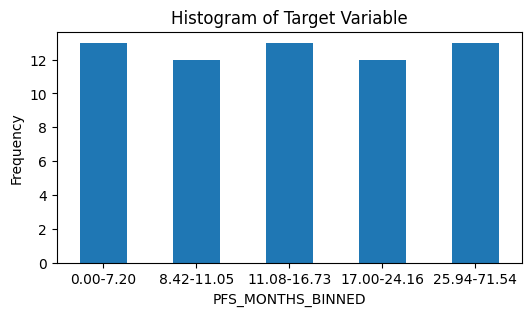

In [26]:
plot_categorical_column_dist(df2, bin_ranges)

In [27]:
X = df2.drop(["PFS_MONTHS", "PFS_MONTHS_BINNED"], axis=1)
y = df2["PFS_MONTHS_BINNED"]

In [28]:
X_processed = preprocess_data(X)

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


## 4. Run X, y thru the models

#### 4.2 Run data through the models

In [29]:
predictions = multiclass_classification(X_processed, y, binary_classification=False)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)

,F1-Score,Recall,Accuracy,Precision
K-Nearest Neighbors,0.313069,0.317949,0.317460,0.324964
Linear SVM,0.308984,0.303846,0.301587,0.327902
Logistic Regression,0.306327,0.302564,0.301587,0.316133
XGBoost,0.289814,0.289744,0.285714,0.291166
Support Vector Machine,0.279250,0.270513,0.269841,0.308309
Random Forest,0.262419,0.271795,0.269841,0.279658
Gradient Boosting,0.227033,0.225641,0.222222,0.234634
Decision Tree,0.143449,0.144872,0.142857,0.146148


#### 4.3 Create function to plot feature importance plot

In [30]:
from sklearn.svm import SVC
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
model = SVC(kernel="linear", decision_function_shape='ovr')
model.fit(X_scaled, y)


SVC(kernel='linear')

In [31]:
model.coef_.shape

(10, 16)

In [32]:
X_scaled.shape, X_processed.shape, X.shape

((63, 16), (63, 16), (63, 15))

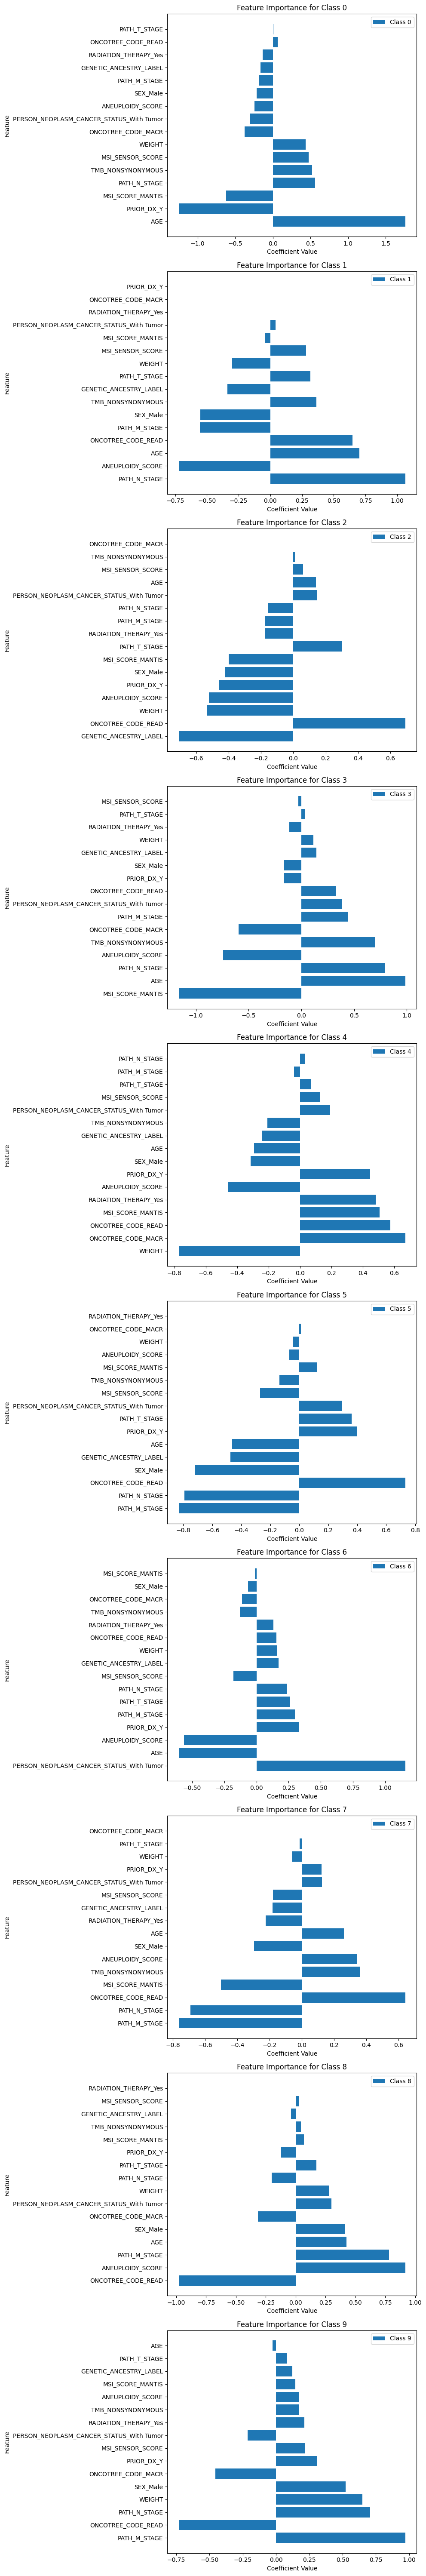

In [33]:
import numpy as np
coefficients = model.coef_
features = X_processed.columns

num_classes = coefficients.shape[0]
fig, axs = plt.subplots(num_classes, 1, figsize=(10, 6 * num_classes))

for i in range(num_classes):
    # Sort the features and coefficients by the absolute value of the coefficients
    sorted_indices = np.argsort(np.abs(coefficients[i]))[::-1]
    sorted_features = np.array(features)[sorted_indices]
    sorted_coefficients = coefficients[i][sorted_indices]

    axs[i].barh(sorted_features, sorted_coefficients)
    axs[i].set_yticks(np.arange(len(sorted_features)))
    axs[i].set_yticklabels(sorted_features)
    axs[i].set_xlabel('Coefficient Value')
    axs[i].set_ylabel('Feature')
    axs[i].set_title(f'Feature Importance for Class {i}')
    axs[i].legend([f'Class {i}'])

plt.tight_layout()
plt.show()




## 5. Experimentation

#### 5.1 Classification with 4 bins

In [36]:
df2, bin_ranges = create_bins(df2, num_of_bins=4)
# plot_categorical_column_dist(df2, bin_ranges)
X = df2.drop(["PFS_MONTHS", "PFS_MONTHS_BINNED"], axis=1)
y = df2["PFS_MONTHS_BINNED"]
X.columns

Index(['AGE', 'SEX', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_T_STAGE',
       'PERSON_NEOPLASM_CANCER_STATUS', 'PRIOR_DX', 'RADIATION_THERAPY',
       'WEIGHT', 'GENETIC_ANCESTRY_LABEL', 'ONCOTREE_CODE', 'ANEUPLOIDY_SCORE',
       'MSI_SCORE_MANTIS', 'MSI_SENSOR_SCORE', 'TMB_NONSYNONYMOUS'],
      dtype='object')

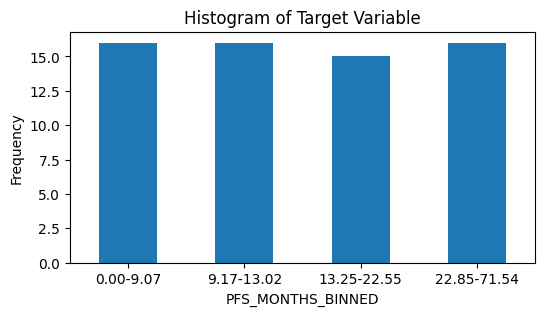

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


,F1-Score,Recall,Accuracy,Precision
K-Nearest Neighbors,0.364296,0.367708,0.365079,0.372024
Support Vector Machine,0.316558,0.319792,0.317460,0.316938
Linear SVM,0.296368,0.302083,0.301587,0.299513
Logistic Regression,0.290943,0.287500,0.285714,0.299185
Decision Tree,0.272280,0.270833,0.269841,0.283628
XGBoost,0.271044,0.270833,0.269841,0.278001
Random Forest,0.229553,0.240625,0.238095,0.233168
Gradient Boosting,0.220646,0.220833,0.222222,0.223572


In [36]:
df2, bin_ranges = create_bins(df2, num_of_bins=4)
plot_categorical_column_dist(df2, bin_ranges)
X = df2.drop(["PFS_MONTHS", "PFS_MONTHS_BINNED"], axis=1)
y = df2["PFS_MONTHS_BINNED"]
X_processed = preprocess_data(X)
predictions = multiclass_classification(X_processed, y, binary_classification=False)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)

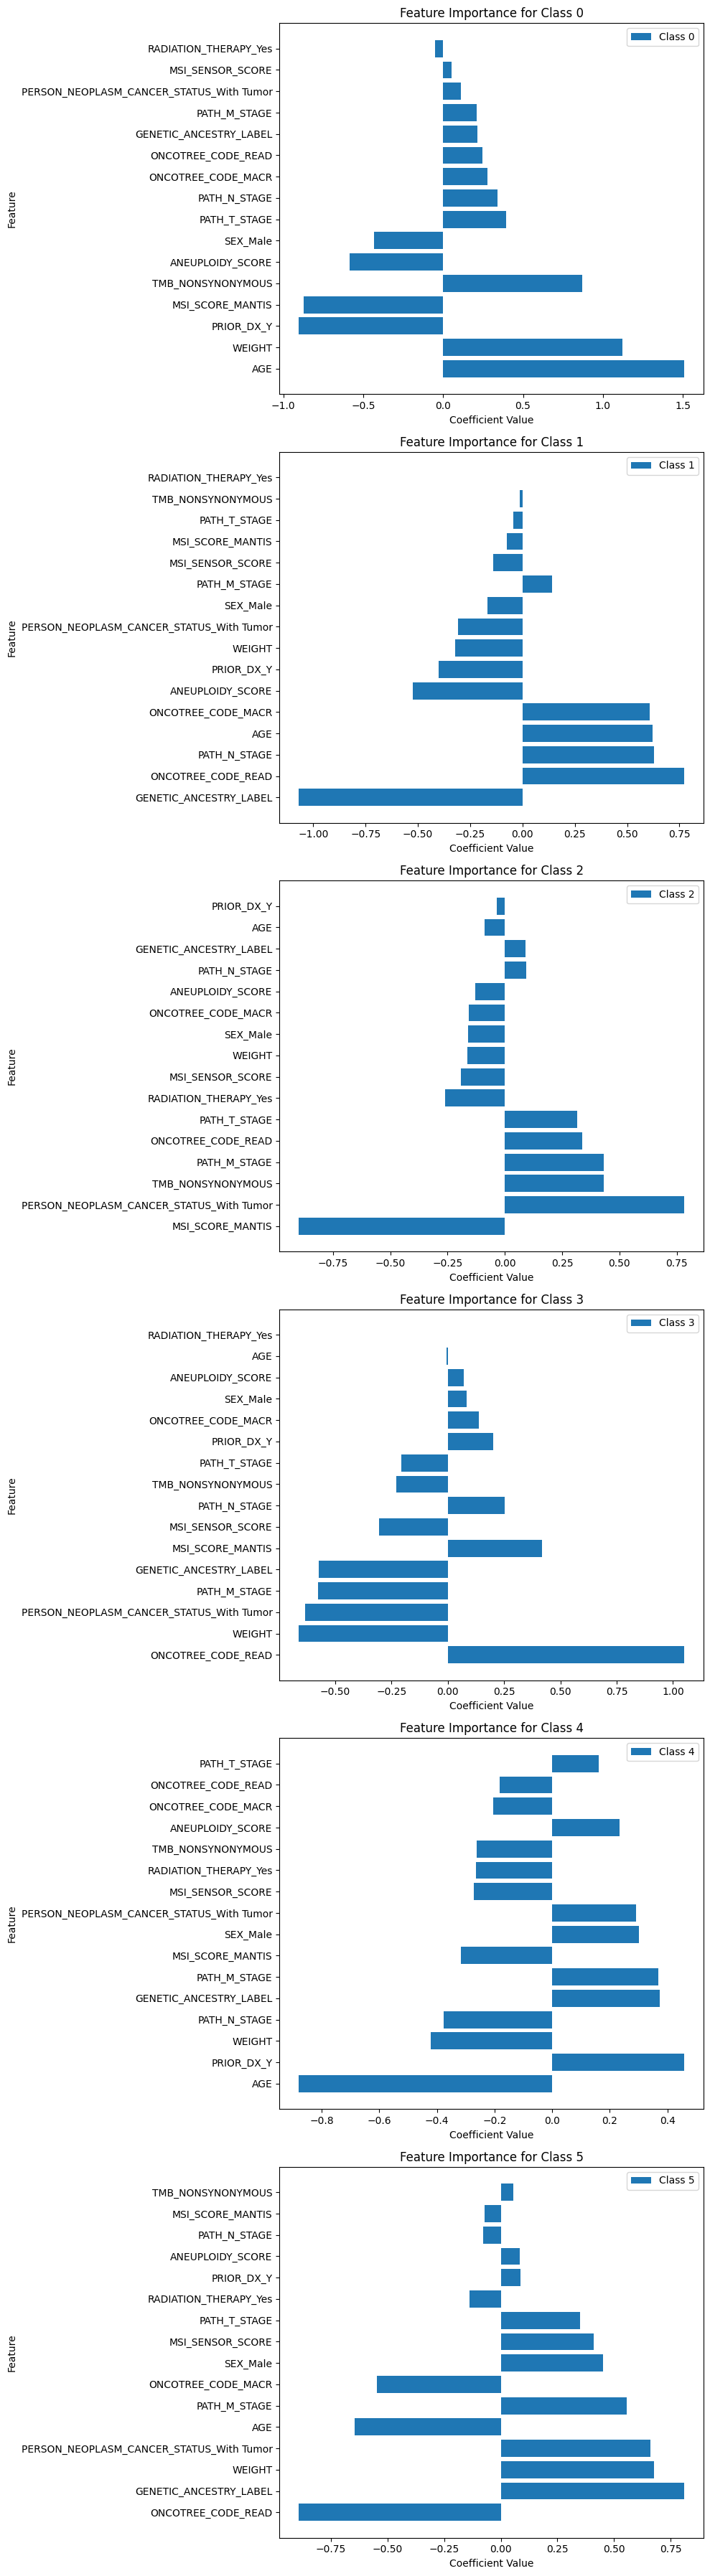

In [33]:
from sklearn.svm import SVC
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
model = SVC(kernel="linear", decision_function_shape='ovr')
model.fit(X_scaled, y)

coefficients = model.coef_
features = X_processed.columns

num_classes = coefficients.shape[0]
fig, axs = plt.subplots(num_classes, 1, figsize=(10, 6 * num_classes))

for i in range(num_classes):
    # Sort the features and coefficients by the absolute value of the coefficients
    sorted_indices = np.argsort(np.abs(coefficients[i]))[::-1]
    sorted_features = np.array(features)[sorted_indices]
    sorted_coefficients = coefficients[i][sorted_indices]

    axs[i].barh(sorted_features, sorted_coefficients)
    axs[i].set_yticks(np.arange(len(sorted_features)))
    axs[i].set_yticklabels(sorted_features)
    axs[i].set_xlabel('Coefficient Value')
    axs[i].set_ylabel('Feature')
    axs[i].set_title(f'Feature Importance for Class {i}')
    axs[i].legend([f'Class {i}'])

plt.tight_layout()
plt.show()

#### 5.2 Experimentation with 3 classes

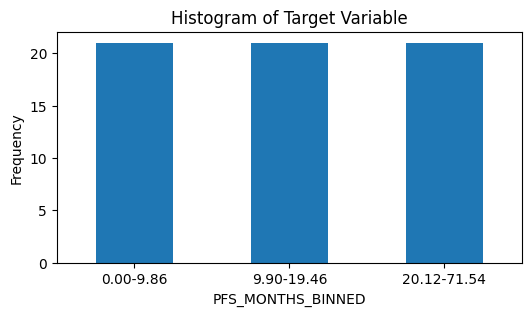

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


,F1-Score,Recall,Accuracy,Precision
Random Forest,0.356508,0.365079,0.365079,0.350490
Decision Tree,0.348820,0.349206,0.349206,0.353544
XGBoost,0.337321,0.333333,0.333333,0.345269
Linear SVM,0.335862,0.333333,0.333333,0.341111
Gradient Boosting,0.329752,0.333333,0.333333,0.328042
K-Nearest Neighbors,0.321691,0.333333,0.333333,0.319048
Logistic Regression,0.315909,0.317460,0.317460,0.318987
Support Vector Machine,0.293088,0.301587,0.301587,0.288590


In [34]:
df2, bin_ranges = create_bins(df2, num_of_bins=3)
plot_categorical_column_dist(df2, bin_ranges)
X = df2.drop(["PFS_MONTHS", "PFS_MONTHS_BINNED"], axis=1)
y = df2["PFS_MONTHS_BINNED"]
X_processed = preprocess_data(X)
predictions = multiclass_classification(X_processed, y, binary_classification=False)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)

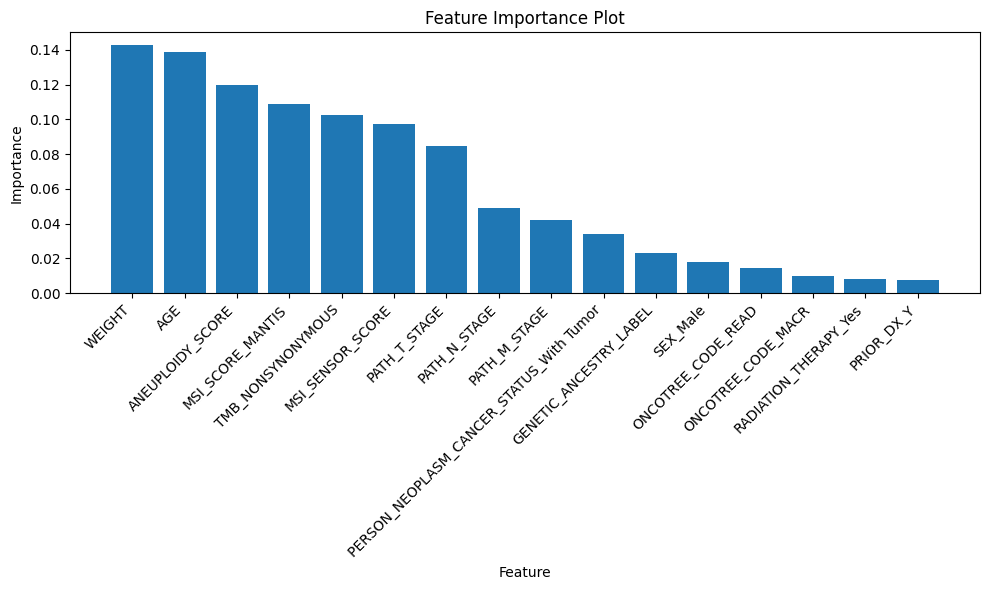

In [35]:
plot_feature_importance_plot_using_rf(X_processed, y)

#### 5.3 Experimentation with 2 classes

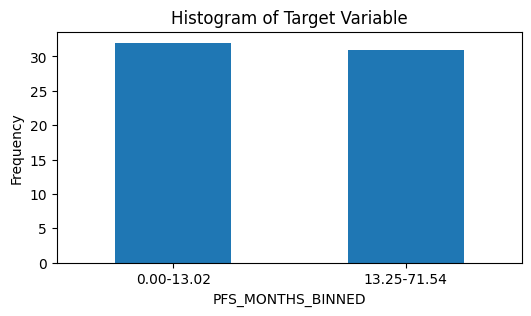

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


,F1-Score,Recall,Accuracy,Precision
Random Forest,0.508475,0.483871,0.539683,0.535714
Decision Tree,0.500000,0.516129,0.492063,0.484848
Linear SVM,0.500000,0.483871,0.523810,0.517241
Gradient Boosting,0.484848,0.516129,0.460317,0.457143
K-Nearest Neighbors,0.476190,0.483871,0.476190,0.468750
XGBoost,0.466667,0.451613,0.492063,0.482759
Support Vector Machine,0.456140,0.419355,0.507937,0.500000
Logistic Regression,0.385965,0.354839,0.444444,0.423077


In [37]:
df2, bin_ranges = create_bins(df2, num_of_bins=2)
plot_categorical_column_dist(df2, bin_ranges)
X = df2.drop(["PFS_MONTHS", "PFS_MONTHS_BINNED"], axis=1)
y = df2["PFS_MONTHS_BINNED"]
X_processed = preprocess_data(X)
predictions = multiclass_classification(X_processed, y, binary_classification=True)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)

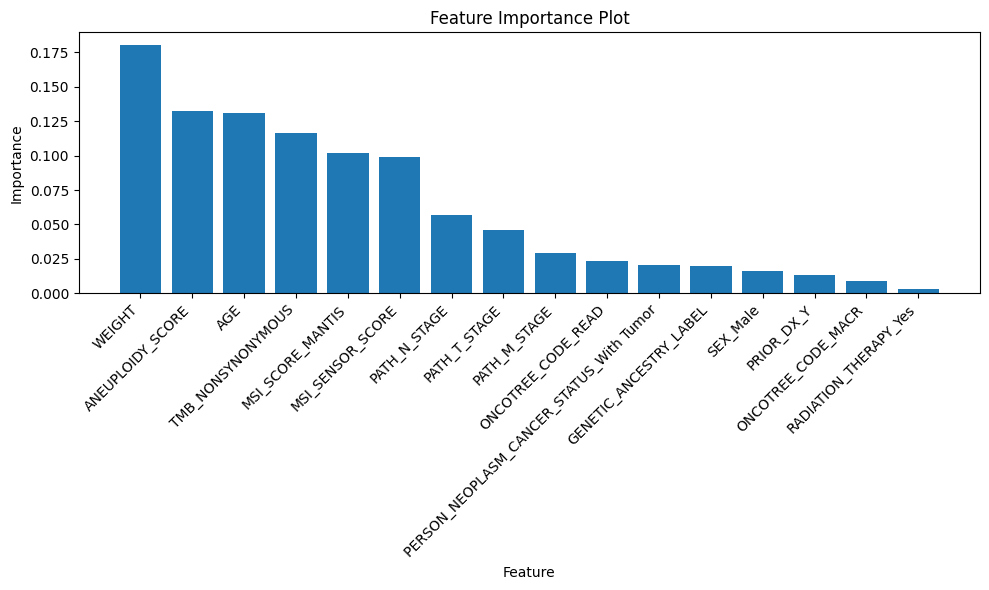

In [38]:
plot_feature_importance_plot_using_rf(X_processed, y)

#### 5.4 Review columns using correlation matrix

In [41]:
def plot_correlation_heatmap(df):
    # Compute the correlation matrix
    corr_matrix = df.corr()
    
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
    
    # Add title
    plt.title('Correlation Matrix Heatmap')
    plt.show()


In [45]:
X_for_cor = X_processed.copy()
X_for_cor["bin"] = y
X_for_cor

,AGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,WEIGHT,GENETIC_ANCESTRY_LABEL,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,SEX_Male,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,PRIOR_DX_Y,RADIATION_THERAPY_Yes,ONCOTREE_CODE_MACR,ONCOTREE_CODE_READ,bin
4,40.0,1.0,2.50,4.0,99.1,0,3.0,0.6600,20.58,62.166667,0,1,0,0,0,0,0
5,76.0,0.0,0.00,3.0,75.4,0,20.0,0.3252,0.47,3.800000,1,1,0,0,0,0,1
6,85.0,1.0,2.00,3.0,67.2,1,25.0,0.3500,0.37,4.066667,1,1,0,0,0,0,1
8,71.0,1.0,2.00,3.0,85.6,1,24.0,0.4577,0.02,7.666667,1,0,0,0,1,0,1
15,73.0,0.0,0.00,3.0,79.6,1,13.0,0.3456,0.13,8.666667,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,50.0,0.0,2.50,3.0,84.4,0,19.0,0.3494,0.57,3.333333,1,0,0,0,0,1,1
567,53.0,0.0,2.50,3.0,82.0,1,8.0,0.3555,0.50,1.733333,1,0,0,0,0,1,0
577,57.0,1.0,1.33,3.0,53.0,1,28.0,0.3401,0.11,3.166667,0,1,0,0,0,1,0
583,62.0,0.0,0.00,3.0,80.0,1,11.0,0.3388,0.35,2.766667,0,0,0,0,0,1,0


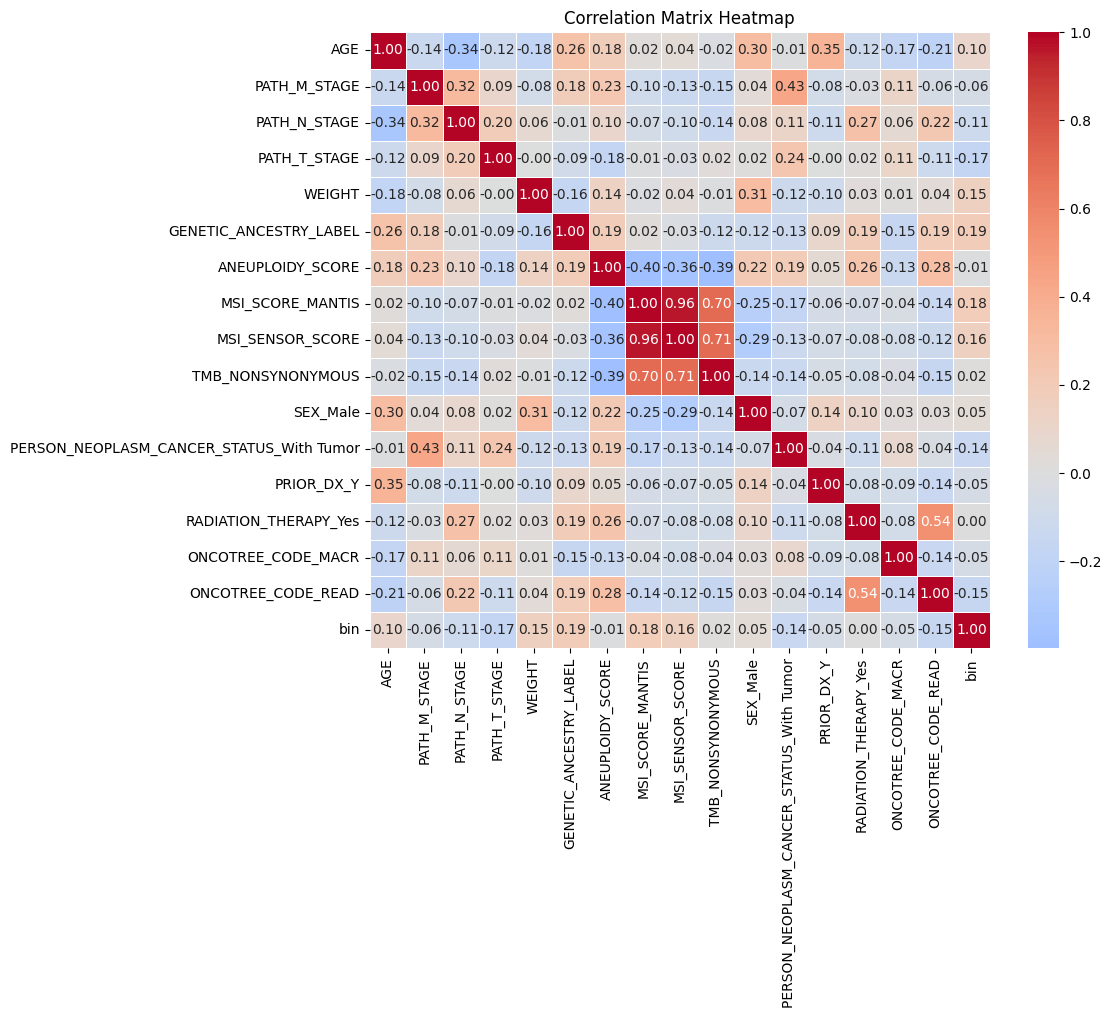

In [46]:
plot_correlation_heatmap(X_for_cor)

#### 5.5 Using only a subset of features and comparing performance

In [52]:
X_processed.columns

Index(['index', 'AGE', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_T_STAGE',
       'WEIGHT', 'GENETIC_ANCESTRY_LABEL', 'ANEUPLOIDY_SCORE',
       'MSI_SCORE_MANTIS', 'MSI_SENSOR_SCORE', 'TMB_NONSYNONYMOUS', 'SEX_Male',
       'PERSON_NEOPLASM_CANCER_STATUS_With Tumor', 'PRIOR_DX_Y',
       'RADIATION_THERAPY_Yes', 'ONCOTREE_CODE_MACR', 'ONCOTREE_CODE_READ'],
      dtype='object')

In [54]:
X_subset = X_processed[[
    "WEIGHT", 
    "ANEUPLOIDY_SCORE", 
    "AGE", 
    "TMB_NONSYNONYMOUS", 
    "MSI_SCORE_MANTIS",
    "PATH_N_STAGE",
    "PATH_T_STAGE",
    "PATH_M_STAGE",
    "ONCOTREE_CODE_READ",
    "PERSON_NEOPLASM_CANCER_STATUS_With Tumor",
    "GENETIC_ANCESTRY_LABEL"
    ]]

In [55]:
predictions = multiclass_classification(X_subset, y, binary_classification=False)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)

,F1-Score,Recall,Accuracy,Precision
K-Nearest Neighbors,0.631579,0.636593,0.634921,0.642632
Linear SVM,0.603175,0.603327,0.603175,0.603327
Support Vector Machine,0.596671,0.601310,0.603175,0.607372
Decision Tree,0.555444,0.555948,0.555556,0.556061
Logistic Regression,0.539218,0.539315,0.539683,0.539394
Random Forest,0.539218,0.539315,0.539683,0.539394
XGBoost,0.459091,0.459677,0.460317,0.459432
Gradient Boosting,0.412698,0.412802,0.412698,0.412802


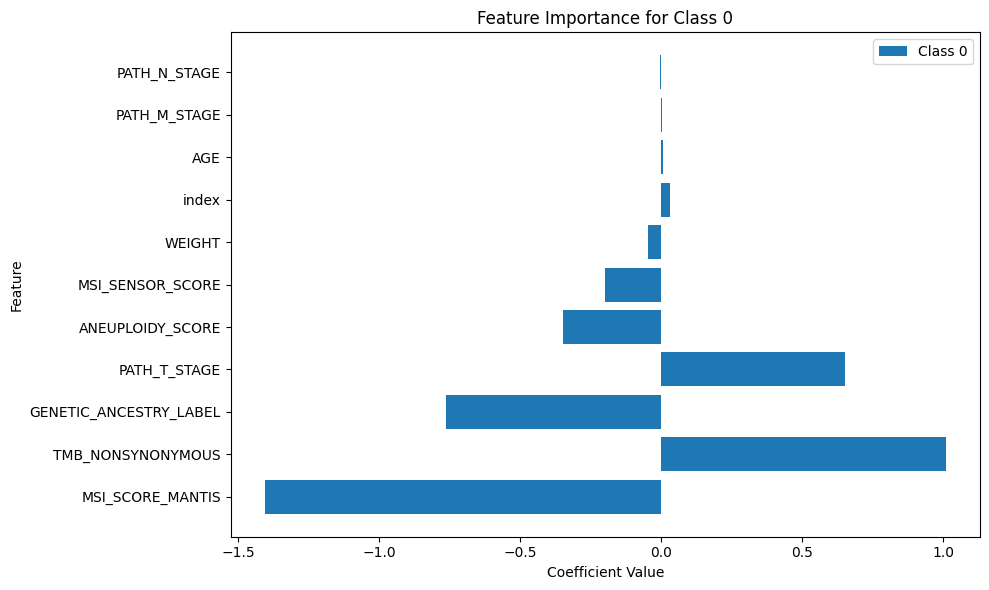

In [58]:
from sklearn.svm import SVC
scaler = StandardScaler()

model = SVC(kernel="linear", decision_function_shape='ovr')
model.fit(X_subset, y)

coefficients = model.coef_
features = X_processed.columns

num_classes = coefficients.shape[0]
fig, axs = plt.subplots(num_classes, 1, figsize=(10, 6 * num_classes))


# Sort the features and coefficients by the absolute value of the coefficients
sorted_indices = np.argsort(np.abs(coefficients[i]))[::-1]
sorted_features = np.array(features)[sorted_indices]
sorted_coefficients = coefficients[i][sorted_indices]

axs.barh(sorted_features, sorted_coefficients)
axs.set_yticks(np.arange(len(sorted_features)))
axs.set_yticklabels(sorted_features)
axs.set_xlabel('Coefficient Value')
axs.set_ylabel('Feature')
axs.set_title(f'Feature Importance for Class {i}')
axs.legend([f'Class {i}'])

plt.tight_layout()
plt.show()